<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/250px-Jupyter_logo.svg.png" alt="Jupyter_logo" class="img-rounded img-responsive" height="60" width="60" align="left">
<span><br><br><br></span>

<h1 align='center' style='margin-bottom: 0px'>Homecredit信贷分析</h1>



***
## 目的：  
按照Homecredit公司提供的贷款人的诸多信息（包括客户特征背景，以往贷款数据），预测贷款消费者的信用违约风险。

数据集包括（本次未使用全部数据集）：
- app_train/test.csv训练和测试数据
- bureau.csv 申请人之前在其他金融机构办理贷款的信息   
- bureau_balance.csv之前办理贷款的月度流水信息
- previous_application.csv 先前申请贷款的流水情况
- POS_CASH_balance.csv 在Homecredit之前的月度信息
- credit_card_balance.csv 在Homecredit办过贷款时的信用卡信息
- installments_payments.csv 之前支付的还款历史
***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline

os.chdir('G:\\project\\keggle_credit\\all\\output')
print(os.listdir('../input'))
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')
bureau = pd.read_csv('../input/bureau.csv')
#bureau_balance = pd.read_csv('../input/bureau_balance.csv')
previous_application = pd.read_csv('../input/previous_application.csv')
#POS_CASH_balance = pd.read_csv('../input/POS_CASH_balance.csv')
#credit_card_balance = pd.read_csv('../input/credit_card_balance.csv')
print('Training data shape:',app_train.shape)
#s = app_train.iloc[0:10,:]
#s.to_csv('E:/py/projects/data_pd/house_credit/ts/s.csv')

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
Training data shape: (307511, 122)


## 数据探索

### 数据概览_application_train

>307511条测试数据中，92%及时偿还贷款，8%未偿还贷款。这是一个不平衡的二分类。

In [2]:
pd.DataFrame(np.vstack((np.array(app_train['TARGET'].value_counts()),np.array(app_train['TARGET'].value_counts())/len(app_train['TARGET']))),index=["counts","rate"]).T

,counts,rate
0,282686.0,0.919271
1,24825.0,0.080729


> 贷款合同：分为循环贷和现金贷.未还贷款中主要为现金贷
> 按照贷款人的性别分组如下，其中4个缺失值

In [3]:
loantype = pd.crosstab(app_train.TARGET, app_train.NAME_CONTRACT_TYPE, dropna=False, normalize='all')
loansex = pd.crosstab(app_train.TARGET, app_train.CODE_GENDER, dropna=False)

In [4]:
app_train = app_train[app_train.CODE_GENDER.isin(['M','F'])]

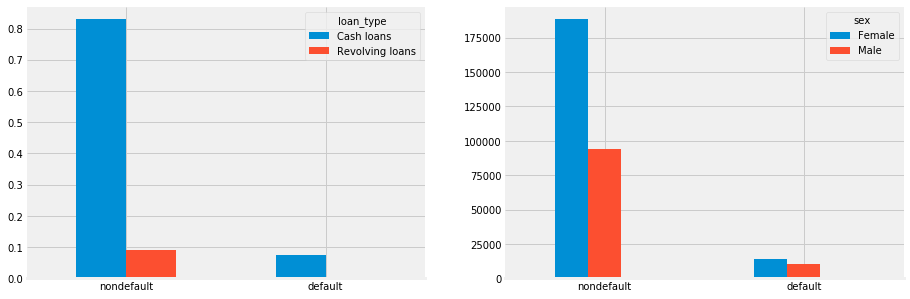

In [5]:
fig,axes = plt.subplots(1,2,figsize=(14,5))#一行两列
loantype.plot(ax = axes[0],kind='bar')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_xticklabels(["nondefault","default"],rotation=360)
axes[0].legend(title='loan_type')


loansex.plot(ax = axes[1],kind='bar')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_xticklabels(["nondefault","default"],rotation=360)
axes[1].legend(['Female','Male'],title='sex')
axes[0].set_xlabel("");axes[1].set_xlabel("")
plt.show() 

> 拥有的不动产和车辆情况

In [6]:
num_re = app_train[app_train.FLAG_OWN_REALTY == 'Y'].shape[0]
percent_re = np.round(app_train[app_train.FLAG_OWN_REALTY == 'Y'].TARGET.value_counts(normalize=True).values[0], 3) * 100
num_car = app_train[app_train.FLAG_OWN_CAR == 'Y'].shape[0]
percent_car = np.round(app_train[app_train.FLAG_OWN_CAR == 'Y'].TARGET.value_counts(normalize=True).values[0], 1) * 100

In [7]:
print("共有{0} 人拥有不动产.其中{1}% 按时还贷.".format(num_re,percent_re))
print("共有{0} 人拥有汽车.其中{1}% 按时还贷.".format(num_car,percent_car))

共有213308 人拥有不动产.其中92.0% 按时还贷.
共有104585 人拥有汽车.其中90.0% 按时还贷.


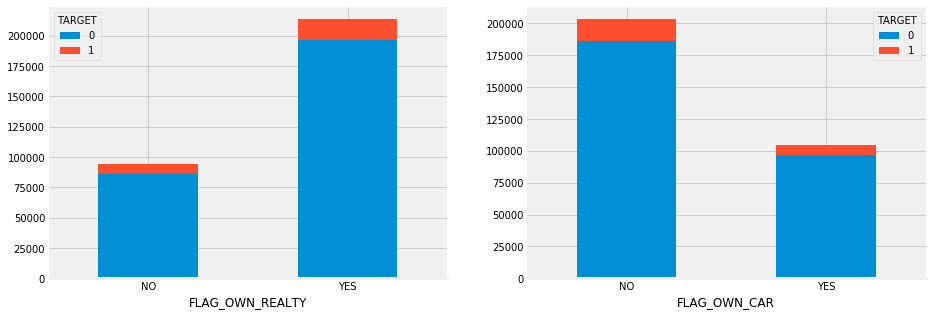

In [8]:
fig,axes = plt.subplots(1,2,figsize=(14,5))#一行两列
pd.crosstab(app_train.FLAG_OWN_REALTY,app_train.TARGET,dropna=False).plot.bar(ax = axes[0],stacked=True)
axes[0].set_xticklabels(["NO","YES"],rotation=0)

pd.crosstab(app_train.FLAG_OWN_CAR,app_train.TARGET,dropna=False).plot.bar(ax = axes[1],stacked=True)
axes[1].set_xticklabels(["NO","YES"],rotation=0)

axes[0].spines['top'].set_visible(False);axes[0].spines['right'].set_visible(False);axes[0].spines['left'].set_visible(False);
axes[1].spines['top'].set_visible(False);axes[1].spines['right'].set_visible(False);axes[1].spines['left'].set_visible(False);
plt.show()

> 家庭信息：贷款人多数为已婚人士，没有小孩的占主要

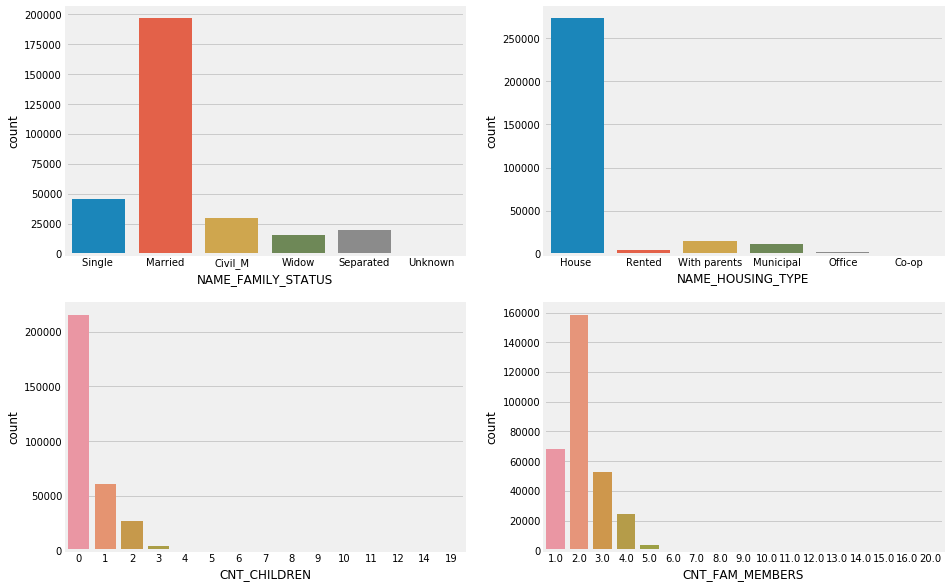

In [9]:
fig,axes = plt.subplots(2,2,figsize=(14,10))#一行两列
sns.countplot(app_train['NAME_FAMILY_STATUS'],ax = axes[0,0])
sns.countplot(app_train['NAME_HOUSING_TYPE'],ax = axes[0,1])
sns.countplot(app_train['CNT_CHILDREN'],ax = axes[1,0])
sns.countplot(app_train['CNT_FAM_MEMBERS'],ax = axes[1,1])
#cmap = sns.light_palette("red",30, as_cmap=False)
#sns.heatmap(pd.crosstab(app_train.CNT_CHILDREN, app_train.CNT_FAM_MEMBERS, dropna=False),linewidths=.5,cmap=cmap,ax = axes[1,0])
axes[0,1].set_xticklabels(['House ','Rented','With parents','Municipal','Office','Co-op'])
axes[0,0].set_xticklabels(['Single ','Married','Civil_M','Widow','Separated','Unknown'])
plt.show()

> 申请人年龄：贷款主力军为25~35年龄段，工作年限越低贷款人数越多
> 申请人职务：劳工是最大的贷款使用者

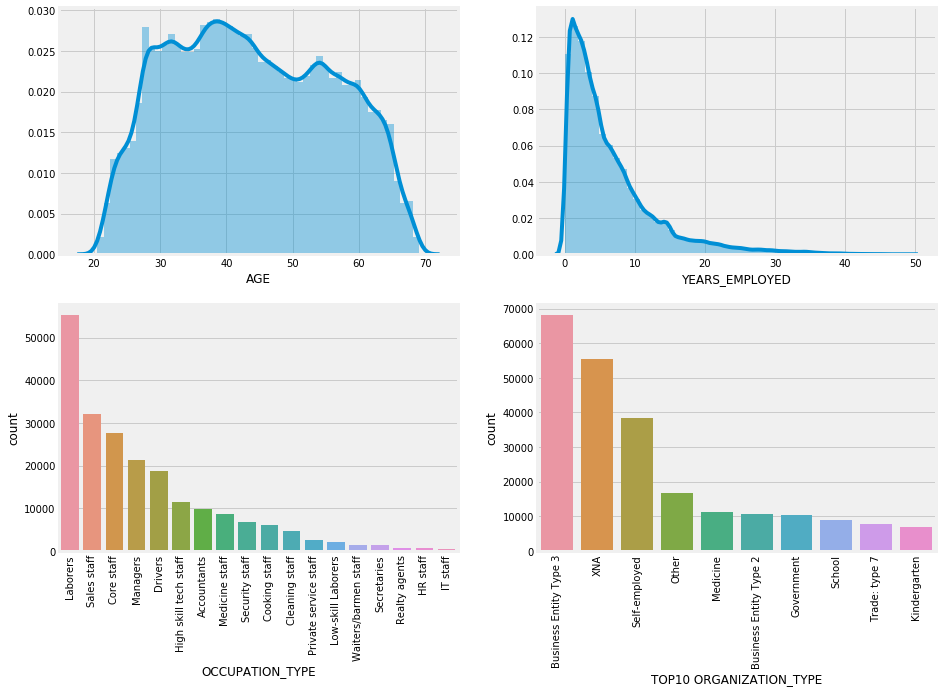

In [10]:
#days employee缺失值5w，使用填充，从事工作年份应该和年龄有关。其实可以不填充了
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
order = ['Laborers', 'Sales staff', 'Core staff', 'Managers', 'Drivers',
       'High skill tech staff', 'Accountants', 'Medicine staff',
       'Security staff', 'Cooking staff', 'Cleaning staff',
       'Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff',
       'Secretaries', 'Realty agents', 'HR staff', 'IT staff']
order1 = ['Business Entity Type 3', 'XNA', 'Self-employed', 'Other', 'Medicine',
       'Business Entity Type 2', 'Government', 'School', 'Trade: type 7',
       'Kindergarten']
fig,axes = plt.subplots(2,2,figsize=(14,10))#
#plt.style.use('fivethirtyeight')
sns.distplot(app_train['DAYS_BIRTH']/-365,ax=axes[0,0]);axes[0,0].set_xlabel('AGE')
sns.distplot(app_train[app_train['DAYS_EMPLOYED'].isnull()==False].DAYS_EMPLOYED/-365,ax=axes[0,1]);axes[0,1].set_xlabel('YEARS_EMPLOYED')
sns.countplot(app_train['OCCUPATION_TYPE'],ax = axes[1,0],order = order)
sns.countplot(app_train[app_train['ORGANIZATION_TYPE'].isin(order1)].ORGANIZATION_TYPE,ax = axes[1,1],order = order1)

#sns.kdeplot(app_train[app_train['TARGET']==0]['DAYS_BIRTH']/-365,label="target==0",ax=axes[1])
#sns.kdeplot(app_train[app_train['TARGET']==1]['DAYS_BIRTH']/-365,label="target==1",ax=axes[1])
axes[1,0].set_xticklabels(labels = order ,rotation=90)
axes[1,1].set_xticklabels(labels = order1 ,rotation=90);axes[1,1].set_xlabel('TOP10 ORGANIZATION_TYPE')
plt.show()

> 申请人主要来自职业中专，薪资水平分布符合职业规律

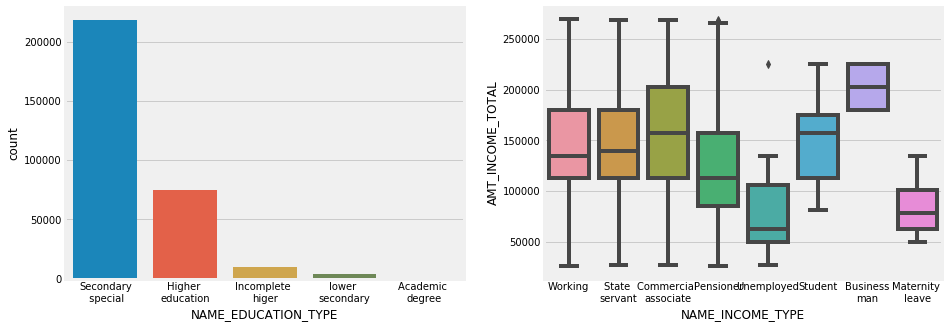

In [11]:
fig,axes = plt.subplots(1,2,figsize=(14,5))

ed_income = app_train[['NAME_EDUCATION_TYPE','AMT_INCOME_TOTAL']]
sns.countplot(x='NAME_EDUCATION_TYPE', data=ed_income,ax = axes[0])
#plt.xticks(np.arange(5),('Secondary\n special','Higher \neducation','Incomplete \nhiger','lower \nsecondary','Academic \ndegree'),rotation=0)
axes[0].set_xticklabels(labels = ['Secondary\n special','Higher \neducation','Incomplete \nhiger','lower \nsecondary','Academic \ndegree'] ,rotation=0)

occ = app_train[app_train['AMT_INCOME_TOTAL'] < np.percentile(app_train['AMT_INCOME_TOTAL'], 90)][['AMT_INCOME_TOTAL','NAME_INCOME_TYPE']]
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="NAME_INCOME_TYPE", y="AMT_INCOME_TOTAL",data=occ,ax = axes[1])
axes[1].set_xticklabels(labels = ['Working','State \nservant','Commercial \nassociate','Pensioner','Unemployed','Student','Business\nman','Maternity \nleave'])
plt.show()


In [12]:
#app_train.groupby(['NAME_INCOME_TYPE']).agg({'AMT_INCOME_TOTAL': ['mean', 'median', 'count']})

> 贷款消费商品价格区间分布和credit额度

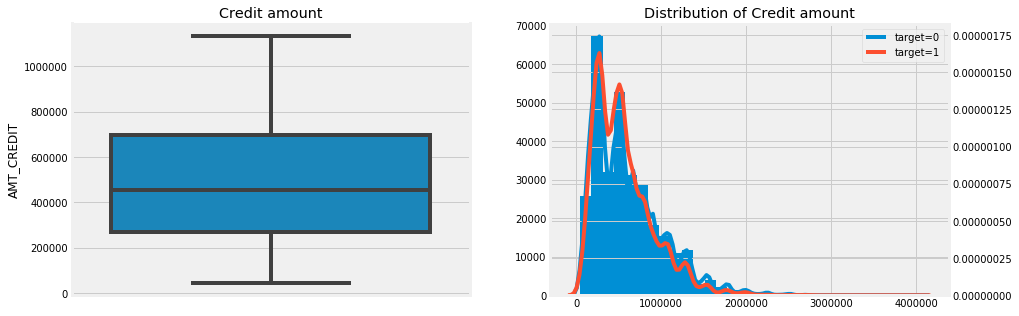

In [13]:
fig,axes = plt.subplots(1,2,figsize=(14,5))#一行两列
#plt.style.use('seaborn-white')
sns.boxplot(app_train[app_train['AMT_CREDIT'] < np.percentile(app_train['AMT_CREDIT'], 90)]['AMT_CREDIT'],orient='v',ax = axes[0])
app_train['AMT_CREDIT'].hist(bins=30,ax = axes[1])
ax2 = axes[1].twinx()
sns.kdeplot(app_train[app_train['TARGET']==0]["AMT_CREDIT"],label="target=0",ax = ax2)
sns.kdeplot(app_train[app_train['TARGET']==1]["AMT_CREDIT"],label="target=1",ax = ax2)
axes[0].set_title('Credit amount');ax2.set_title('Distribution of Credit amount');
plt.show()

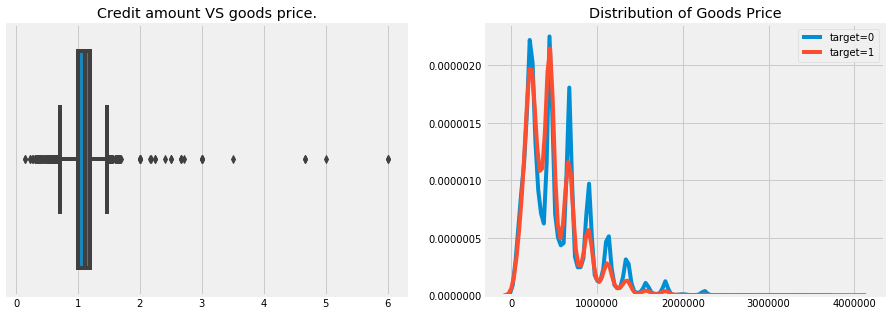

In [14]:
#看商品介格和贷款的价格是否接近
fig,axes = plt.subplots(1,2,figsize=(14,5))#一行两列
non_zero_good_price = app_train[app_train['AMT_GOODS_PRICE'].isnull() == False]
credit_to_good_price = non_zero_good_price['AMT_CREDIT'] / non_zero_good_price['AMT_GOODS_PRICE']
sns.boxplot(credit_to_good_price,ax = axes[0]);
sns.kdeplot(app_train[(app_train['TARGET']==0)&(app_train["AMT_GOODS_PRICE"].isnull() == False)]["AMT_GOODS_PRICE"],label="target=0",ax = axes[1])
sns.kdeplot(app_train[(app_train['TARGET']==1)&(app_train["AMT_GOODS_PRICE"].isnull() == False)]["AMT_GOODS_PRICE"],label="target=1",ax = axes[1])
axes[0].set_title('Credit amount VS goods price.');axes[1].set_title('Distribution of Goods Price');

In [15]:
#cm = sns.light_palette("#d65f5f", as_cmap=True)
#s = pd.crosstab(app_train.NAME_INCOME_TYPE, app_train.OCCUPATION_TYPE, dropna=False).style.background_gradient(cmap="viridis", low=.5, high=0).highlight_null('red')

### 关联分析

In [16]:
corr = abs(app_train.corr())['TARGET'].sort_values(ascending = False)
print('Top10 Correlation Values:\n', corr.head(10))

Top10 Correlation Values:
 TARGET                         1.000000
EXT_SOURCE_3                   0.178926
EXT_SOURCE_2                   0.160471
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078242
DAYS_EMPLOYED                  0.074957
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
Name: TARGET, dtype: float64


In [17]:
app_test["DAYS_BIRTH"] = abs(app_test["DAYS_BIRTH"])
app_train["DAYS_BIRTH"] = abs(app_train["DAYS_BIRTH"])

In [18]:
ext_source_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
corrmat = ext_source_data.corr()

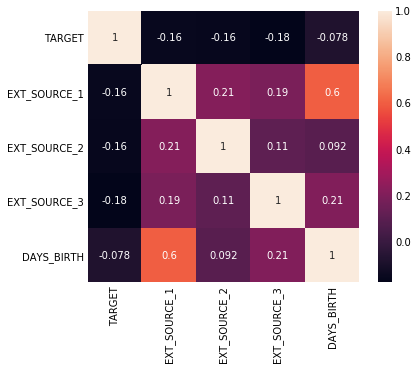

In [19]:
#sns_plot = sns.heatmap(data=ext_source_data_corr, annot=True, vmax=0.6, cmap='Purples')
plt.figure(figsize=(6,5))
sns.heatmap(corrmat,square = True,annot=True)
plt.show()

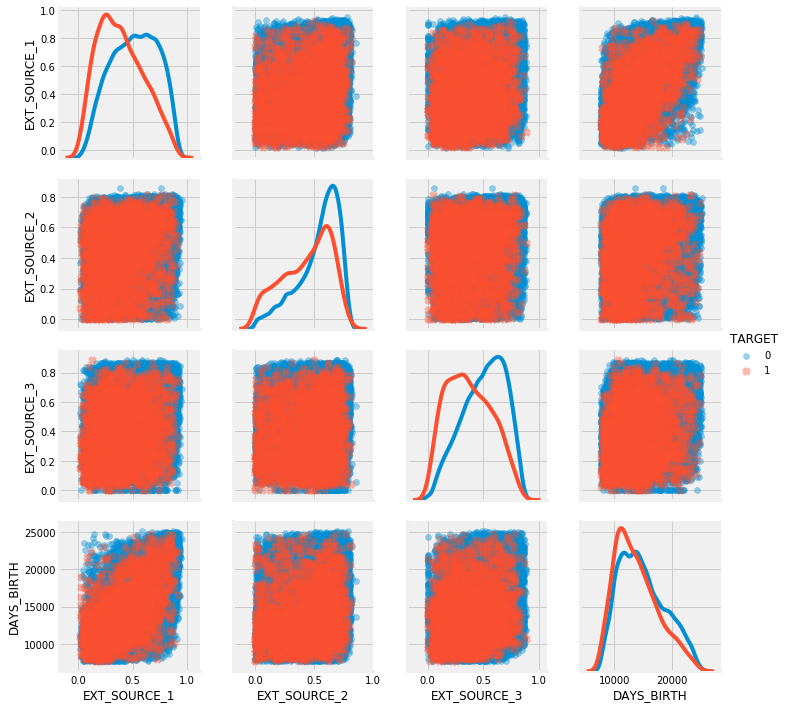

In [20]:
ext_source_data=ext_source_data.dropna().loc[:100000,:]
h = sns.PairGrid(ext_source_data,hue='TARGET',hue_kws={"marker": ["o","x"]},\
                 diag_sharey = False,vars = [x for x in list(ext_source_data.columns) if x != 'TARGET'] )
h.map_upper(plt.scatter,alpha = 0.4)
h.map_lower(plt.scatter,alpha = 0.4)
h.map_diag(sns.kdeplot)
h.add_legend()
plt.show()

#### bureau&previous_application数据

In [21]:
#bureau数据
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU','CREDIT_CURRENCY']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

In [22]:
columns = ['SK_ID_CURR']
for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))
bureau_agg.columns = columns
bureau_agg['is']='is'
tar = app_train[['SK_ID_CURR','TARGET']]
tar_merge = tar.merge(bureau_agg,on='SK_ID_CURR',how='left')
merge_train_unnum = tar_merge[tar_merge['is'].isnull()==False]

In [23]:
#previous_application数据
previous_agg = previous_application.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
precolumns = ['SK_ID_CURR']
for var in previous_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in previous_agg.columns.levels[1][:-1]:
            precolumns.append('previous_%s_%s' % (var, stat))
previous_agg.columns = precolumns
previous_agg['is']='is'
tar = app_train[['SK_ID_CURR','TARGET']]
pretar_merge = tar.merge(previous_agg,on='SK_ID_CURR',how='left')
premerge_train_unnum = pretar_merge[pretar_merge['is'].isnull()==False]


In [24]:
#这几个相关性不强
previous_agg_corr = abs(premerge_train_unnum.corr())
previous_agg_corr.sort_values('TARGET', ascending=False)['TARGET'].head()

TARGET                              1.000000
previous_DAYS_DECISION_min          0.053431
previous_DAYS_FIRST_DRAWING_mean    0.048801
previous_DAYS_DECISION_mean         0.046865
previous_DAYS_FIRST_DRAWING_min     0.044641
Name: TARGET, dtype: float64

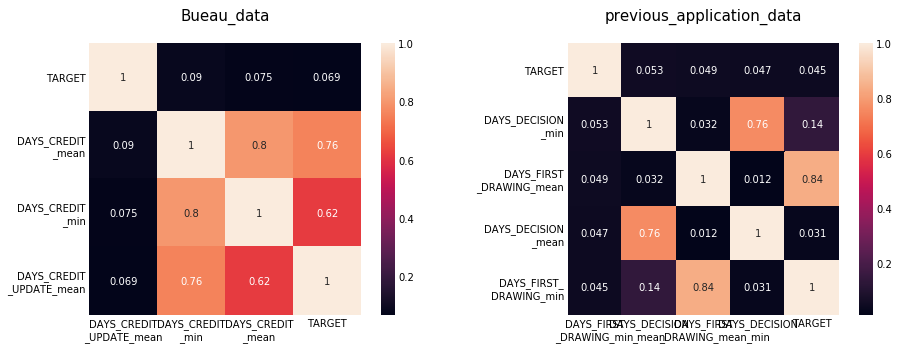

In [25]:

fig,axes = plt.subplots(1,2,figsize=(14,5))#一行两列
xlab = ['DAYS_CREDIT\n_UPDATE_mean','DAYS_CREDIT\n_min','DAYS_CREDIT\n_mean','TARGET']
ylab =['TARGET','DAYS_CREDIT\n_mean','DAYS_CREDIT\n_min','DAYS_CREDIT\n_UPDATE_mean']

xlabs = ['DAYS_FIRST\n_DRAWING_min','DAYS_DECISION\n_mean','DAYS_FIRST\n_DRAWING_mean','DAYS_DECISION\n_min','TARGET']
ylabs = ['TARGET','DAYS_DECISION\n_min','DAYS_FIRST\n_DRAWING_mean','DAYS_DECISION\n_mean','DAYS_FIRST_\nDRAWING_min']

sns.heatmap(merge_train_unnum[['TARGET','bureau_DAYS_CREDIT_mean','bureau_DAYS_CREDIT_min',\
                               'bureau_DAYS_CREDIT_UPDATE_mean']].corr(),square = True,annot=True,xticklabels=xlab,yticklabels=ylab,ax=axes[0])
#plt.xticks(rotation=0) 

sns.heatmap(abs(premerge_train_unnum[['TARGET','previous_DAYS_DECISION_min','previous_DAYS_FIRST_DRAWING_mean','previous_DAYS_DECISION_mean',\
                               'previous_DAYS_FIRST_DRAWING_min']].corr()),square = True,annot=True,xticklabels=xlabs,yticklabels=ylabs,ax=axes[1])
axes[0].set_xticklabels(labels = xlab ,rotation=0);axes[1].set_xticklabels(labels = xlabs ,rotation=0)
axes[0].set_title("Bueau_data\n",fontsize=15);axes[1].set_title("previous_application_data\n",fontsize=15)
plt.show()

In [26]:
#查看重复的数据
#previous_application[previous_application['SK_ID_CURR'].duplicated(keep = False)].drop_duplicates()

In [27]:
#对previous_application 'object'类型字段分析：两表很多字段相似，鉴于application_train中对相关性的探索结果，
#只使用NAME_CONTRACT_STATUS和DAYS_DECISION两个字段
#pre_obj = 对previous_application.select_dtypes(include = "object")
pre_obj = previous_application[["SK_ID_CURR","NAME_CONTRACT_STATUS","DAYS_DECISION"]]

In [28]:
#NAME_CONTRACT_STATUS
pre_obj.DAYS_DECISION = abs(pre_obj.DAYS_DECISION)
pre_obj['id']=1
pre_obj_tab = pd.pivot_table(pre_obj[["SK_ID_CURR","NAME_CONTRACT_STATUS","id"]],index='SK_ID_CURR',columns='NAME_CONTRACT_STATUS',values="id",aggfunc='count')
pre_obj_tab = pre_obj_tab.drop("Unused offer",axis=1)
pre_obj_tab = pre_obj_tab.fillna(0).reset_index()

#DAYS_DECISION
pre_obj_agg = pre_obj[["SK_ID_CURR","DAYS_DECISION"]].groupby('SK_ID_CURR',as_index = False).agg(['count','mean','max','min','sum'])
obj_columns = ["previous_DAYS_DECISION"+stat for stat in pre_obj_agg.columns.levels[1]]
pre_obj_agg.columns = obj_columns

In [29]:
#数据整合
obj_merge = pre_obj_tab.merge(pre_obj_agg,on='SK_ID_CURR',how='left')
obj_tar_merge = tar.merge(obj_merge,on = "SK_ID_CURR",how = "left")
obj_tar_merge = obj_tar_merge[obj_tar_merge["previous_DAYS_DECISIONcount"].isnull()==False]

#previous_application
previous_app = previous_agg.drop('is',axis=1).merge(obj_merge,on='SK_ID_CURR',how='left')

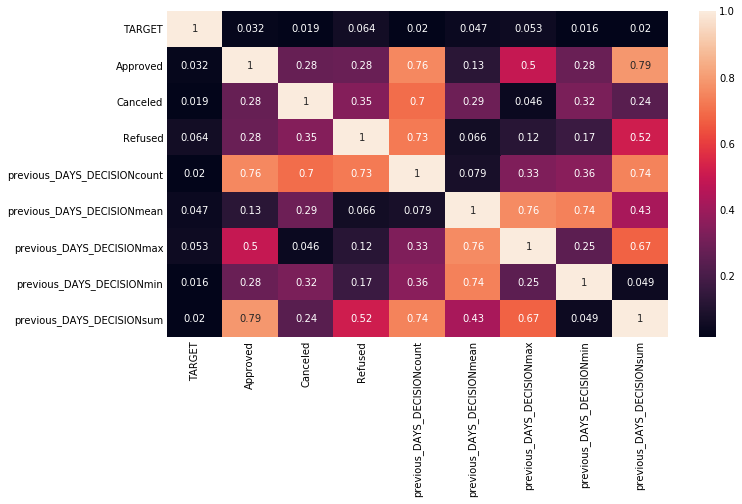

In [30]:
plt.style.use({'figure.figsize':(10, 6)}) 
sns.heatmap(abs(obj_tar_merge.drop("SK_ID_CURR",axis = 1).corr()),annot=True)
plt.show()

### 整合数据 app_train&bureau&previous_application

In [31]:
merge_train = app_train.merge(bureau_agg.drop('is',axis=1),on = 'SK_ID_CURR',how = "left")
merge_train_data = merge_train.merge(previous_app,on = 'SK_ID_CURR',how = "left")

merge_test = app_test.merge(bureau_agg.drop('is',axis=1),on = 'SK_ID_CURR',how = "left")
merge_test_data = merge_test.merge(previous_app,on = 'SK_ID_CURR',how = "left")


## 数据预处理

### 缺失值处理

In [32]:
def missing_value_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum()*100/len(df) #缺失百分比
    mis_val_df = pd.concat([mis_val,mis_val_percent],axis=1)
    mis_val_df.columns=['Missing Values','% of total values']
    nomis_val = mis_val_df[mis_val_df['Missing Values']!=0] #有缺失值的列
    mis_val_df.sort_values(by='% of total values',ascending = False,inplace=True)
    mis_val_table_ren_columns=mis_val_df.round(1)
    #缺失值情况
    print("there is total",df.shape[1],"columns.\n","there are",nomis_val.shape[0],"has missing value.")
    return mis_val_table_ren_columns
    
missing_values = missing_value_table(app_train)
missing_values.head(20)

there is total 123 columns.
 there are 68 has missing value.


,Missing Values,% of total values
COMMONAREA_MEDI,214862,69.9
COMMONAREA_AVG,214862,69.9
COMMONAREA_MODE,214862,69.9
NONLIVINGAPARTMENTS_MEDI,213512,69.4
NONLIVINGAPARTMENTS_MODE,213512,69.4
NONLIVINGAPARTMENTS_AVG,213512,69.4
FONDKAPREMONT_MODE,210293,68.4
LIVINGAPARTMENTS_AVG,210197,68.4
LIVINGAPARTMENTS_MODE,210197,68.4
LIVINGAPARTMENTS_MEDI,210197,68.4


In [33]:
#train data
appli_clean_train=merge_train_data

flt_col = appli_clean_train.columns[appli_clean_train.dtypes==float]
appli_clean_train[flt_col] = appli_clean_train[flt_col].fillna(appli_clean_train[flt_col].mean())

obj_col = appli_clean_train.columns[appli_clean_train.dtypes==object]
appli_clean_train[obj_col] = appli_clean_train[obj_col].fillna(appli_clean_train[obj_col].mode())

In [34]:
#teat data
appli_clean_test=merge_test_data

flt_col = appli_clean_test.columns[appli_clean_test.dtypes==float]
appli_clean_test[flt_col] = appli_clean_test[flt_col].fillna(appli_clean_test[flt_col].mean())

obj_col = appli_clean_test.columns[appli_clean_test.dtypes==object]
appli_clean_test[obj_col] = appli_clean_test[obj_col].fillna(appli_clean_test[obj_col].mode())

#剩下的空缺太多的可以拿掉了

### 根据业务领域转换部分特征值
- AMT_INCOME_TOTAL（年工资） AMT_CREDIT（放贷金额）  AMT_ANNUITY（等额年金）：年金和薪资都会分别对贷款人的贷款金额和还款能力产生影响

In [35]:
appli_clean_train['CREDIT_INCOME'] = appli_clean_train['AMT_CREDIT'] / appli_clean_train['AMT_INCOME_TOTAL']
appli_clean_train['ANNUITY_CREDIT'] = appli_clean_train['AMT_ANNUITY'] / appli_clean_train['AMT_CREDIT']

appli_clean_test['CREDIT_INCOME'] = appli_clean_test['AMT_CREDIT'] / appli_clean_test['AMT_INCOME_TOTAL']
appli_clean_test['ANNUITY_CREDIT'] = appli_clean_test['AMT_ANNUITY'] / appli_clean_test['AMT_CREDIT']

In [36]:
#备份填好的数据


appli_clean_train.to_csv('application_train_clean.csv')
appli_clean_test.to_csv('application_test_clean.csv')
missing_val = appli_clean_train.isnull().sum().sort_values(ascending=False)
missing_val.head(10)


FONDKAPREMONT_MODE     210293
WALLSMATERIAL_MODE     156340
HOUSETYPE_MODE         154296
EMERGENCYSTATE_MODE    145754
OCCUPATION_TYPE         96389
NAME_TYPE_SUITE          1292
FLAG_DOCUMENT_9             0
FLAG_DOCUMENT_8             0
FLAG_DOCUMENT_7             0
FLAG_DOCUMENT_6             0
dtype: int64

### one-hot encoding

In [37]:
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    one_hot = pd.get_dummies(df, columns= categorical_columns)
    df = df.drop(columns=categorical_columns,axis = 1)
    df=df.merge(one_hot)
    return df

In [38]:
appli_clean_train = one_hot_encoder(appli_clean_train)
appli_clean_test = one_hot_encoder(appli_clean_test)

## 模型测试&选择

### 使用交叉验证

In [39]:
train_target = appli_clean_train['TARGET']
appli_clean_train,appli_clean_test=appli_clean_train.align(appli_clean_test,join="inner",axis=1)

In [40]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.metrics import roc_curve,auc
import lightgbm as lgb

In [41]:
X_train = appli_clean_train.drop(['SK_ID_CURR'], axis=1)
Y_train = train_target
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)
# 标准化
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [42]:
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_clfs = lr_clf.score(x_test, y_test) * 100
print("Logistic Regr Score = ", round(lr_clfs,4))

Logistic Regr Score =  91.9549


In [43]:
rand_clf = RandomForestClassifier()
rand_clf.fit(x_train, y_train)
rand_clfs = rand_clf.score(x_test, y_test) * 100
print("Random Forest Score = ", round(rand_clfs,4))

Random Forest Score =  91.8741


In [44]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(x_train, y_train) 
lgb_clfs = lgb_clf.score(x_test, y_test) * 100
print("LGBM Score = ", round(lgb_clfs,4))

LGBM Score =  91.9973


F:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 使用LightGBM建立预测模型

In [45]:
lgb_x = appli_clean_train
lgb_y = train_target

#数据拆分
x, val_x, y, val_y = train_test_split(lgb_x,lgb_y,test_size=0.2, random_state=21)
#训练
X = x.drop('SK_ID_CURR',axis=1)
#验证
val_X = val_x.drop('SK_ID_CURR',axis=1)
#测试
x_test = appli_clean_test.drop('SK_ID_CURR',axis=1)

#数据转换
lgb_train = lgb.Dataset(X, label=y)
lgb_eval = lgb.Dataset(val_X, label=val_y)


params={'num_leaves':150, 
        'boosting_type': 'gbdt',
          'objective':'binary',
          'max_depth':7,
          'learning_rate':.05,
          'max_bin':200}
num_round = 100
clf = lgb.train(params,lgb_train, num_round,valid_sets=[lgb_eval])
y_pre = clf.predict(val_X)

#y_pred=clf.predict(x_test)
#y_pred

[1]	valid_0's binary_logloss: 0.274695
[2]	valid_0's binary_logloss: 0.272249
[3]	valid_0's binary_logloss: 0.270123
[4]	valid_0's binary_logloss: 0.268289
[5]	valid_0's binary_logloss: 0.266614
[6]	valid_0's binary_logloss: 0.265166
[7]	valid_0's binary_logloss: 0.263793
[8]	valid_0's binary_logloss: 0.262593
[9]	valid_0's binary_logloss: 0.261511
[10]	valid_0's binary_logloss: 0.260493
[11]	valid_0's binary_logloss: 0.259548
[12]	valid_0's binary_logloss: 0.258682
[13]	valid_0's binary_logloss: 0.257904
[14]	valid_0's binary_logloss: 0.257185
[15]	valid_0's binary_logloss: 0.256458
[16]	valid_0's binary_logloss: 0.255754
[17]	valid_0's binary_logloss: 0.255178
[18]	valid_0's binary_logloss: 0.254545
[19]	valid_0's binary_logloss: 0.254017
[20]	valid_0's binary_logloss: 0.253474
[21]	valid_0's binary_logloss: 0.253036
[22]	valid_0's binary_logloss: 0.252547
[23]	valid_0's binary_logloss: 0.252097
[24]	valid_0's binary_logloss: 0.251679
[25]	valid_0's binary_logloss: 0.25129
[26]	valid

In [46]:
fpr, tpr, thresholds = roc_curve(val_y, y_pre, pos_label=1)
AUC_ROC = roc_auc_score(val_y, y_pre)

(0.0, 1.0)

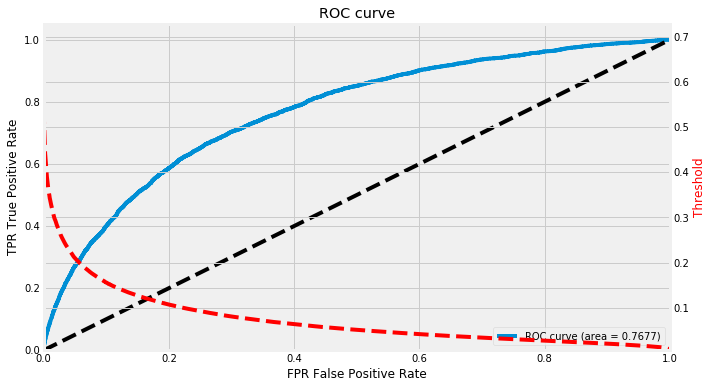

In [47]:
roc_auc = auc(fpr, tpr) 
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR False Positive Rate')
plt.ylabel('TPR True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
 
# 绘制阈值
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [48]:
y_pred = clf.predict(x_test,num_iteration=clf.best_iteration)

In [49]:
output = pd.DataFrame({'SK_ID_CURR': appli_clean_test['SK_ID_CURR'][:48744],'RATE': y_pred})
output['TARGET']= np.where(output['RATE']<=0.17, 0, 1)
output

,SK_ID_CURR,RATE,TARGET
0,100001,0.037242,0
1,100005,0.091638,0
2,100013,0.024164,0
3,100028,0.044130,0
4,100038,0.183232,1
5,100042,0.038067,0
6,100057,0.016666,0
7,100065,0.027730,0
8,100066,0.028415,0
9,100067,0.158691,0
